# **Prueba de concepto para el análisis de la criticidad de la red eléctrica en Caldas**


El departamento de Caldas, en Colombia, enfrenta desafíos significativos en la gestión de su red eléctrica debido a su topografía montañosa y variaciones de altitud. Para abordar estos retos, se ha realizado una prueba de concepto meidnate el analisis exploratorio de las bases de datos proporcionadas por el operador de red CHEC. Este primer estudio permite identificar los posibles puntos más vulnerables de la red y desarrollar estrategias preventivas para mitigar posibles fallos, mejorando así la fiabilidad del sistema y los indicadores de calidad media (SAIDI y SAIFI).

La implementación de técnicas de inteligencia artificial en este análisis facilita la detección de patrones complejos y correlaciones en grandes volúmenes de datos, Utilizando algoritmos de aprendizaje automático, se pueden predecir las condiciones que preceden a los fallos en los circuitos, teniendo en cuenta factores geográficos, ambientales y tecnicos.



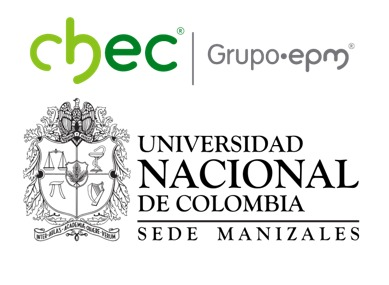


**Objetivo**

El objetivo general de esta prueba de concepto fue realizar un analisis exploratorio de las bases de datos suministradas por el operador de red,
para la deteccion de los posibles factores que aportan a la criticidad de la red eléctrica en el departamento de Caldas, Colombia.









# **Instalación e importe de librerías**



---



In [ ]:
pip install contextily

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 16.6 MB/s eta 0:00:00


In [ ]:
import os
import warnings

import contextily as ctx
import geopandas as gpd
import pandas as pd
import numpy as np
import folium
from folium.plugins import MarkerCluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Point, Polygon, MultiPoint
from scipy.special import softmax
from scipy.optimize import minimize

from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Mounted at /content/drive


In [ ]:
# @title Carga de datos
ruta_carpeta = '/content/drive/Shareddrives/CHEC/data_chec/datos/INFORMACION_UNIVERSIDAD'
files = list(filter(lambda s:s.endswith('.shp'), os.listdir(ruta_carpeta)))
files

['APOYOS.shp',
 'SWITCHES.shp',
 'RAYOS.shp',
 'TRANSFORMADORES.shp',
 'CIRCUITOS.shp']

In [ ]:
# @title .
geo_dataframes = [gpd.read_file(os.path.join(ruta_carpeta, name)) for name in files]

# **Apoyos**


---



In [ ]:
apoyos = geo_dataframes[0]

# **Interruptores**


---



In [ ]:
switches = geo_dataframes[1]


# **DESCARGAS**



---



In [ ]:
rayos = geo_dataframes[2]

# **Transformadores**

In [ ]:
transformadores = geo_dataframes[3]

# **Circuitos**


---



In [ ]:
circuitos = geo_dataframes[4]

In [ ]:
circuitos.columns.tolist()

['G3E_FID',
 'CODIGO',
 'CIRCUITO',
 'TENSION',
 'FASES',
 'LONGITUD',
 'LOCALIZACI',
 'CODE_CONDU',
 'CALIBRE_F',
 'MATERIAL_F',
 'TIPO_AISLA',
 'AISLAMIENT',
 'CODE_NEUTR',
 'CALIBRE_NE',
 'PROPIETARI',
 'NODO1_ID',
 'NODO2_ID',
 'ESTADO',
 'FECHA_COLO',
 'FECHA_MODI',
 'GLOBALID',
 'NOMBRE_PRO',
 'CLASIFICAC',
 'FINALIDAD_',
 'TIPO_PROYE',
 'TRABAJO_PR',
 'USUARIO_MO',
 'EST_ESTABL',
 'FECHA_INST',
 'DEPARTAMEN',
 'MUNICIPIO',
 'TENSION_LO',
 'ESTADO_EST',
 'geometry']

In [ ]:
circuitos.CIRCUITO

,CIRCUITO
0,NSA23L14
1,NSA23L12
2,NSA23L14
3,NSA23L12
4,NSA23L13
...,...
1369,FLR23L15
1370,FLR23L15
1371,NSA23L14
1372,FLR23L15


# **Interrupciones**


---



In [ ]:
archivo_excel = '/content/drive/Shareddrives/CHEC/data_chec/datos/INFORMACION_UNIVERSIDAD/interrupciones_NSA_2023_2.xlsx'
interrupciones = pd.read_excel(archivo_excel)

In [ ]:

# Convertir la columna 'inicio' a formato de fecha y hora
interrupciones['inicio'] = pd.to_datetime(interrupciones['inicio'], format='%Y-%m-%d %H:%M:%S')

# Filtrar las interrupciones del día 2023-10-22
fecha_especifica = '2023-10-22'
interrupciones_dia = interrupciones[interrupciones['inicio'].dt.strftime('%Y-%m-%d') == fecha_especifica]

# Asegurar que la columna 'TRAFO' en interrupciones sea de tipo string
interrupciones_dia['TRAFO'] = interrupciones_dia['TRAFO'].astype(str)

# Asegurarse que las columnas 'CODIGO' en transformadores y switches también sean string
transformadores['CODIGO'] = transformadores['CODIGO'].astype(str)
switches['CODIGO'] = switches['CODIGO'].astype(str)

# Buscar la ubicación en la tabla de transformadores utilizando 'CODIGO'
interrupciones_dia = interrupciones_dia.merge(transformadores[['CODIGO', 'geometry']],
                                              left_on='TRAFO', right_on='CODIGO', how='left', suffixes=('', '_transformador'))

# Buscar la ubicación en la tabla de switches donde no se encontró en transformadores
interrupciones_dia = interrupciones_dia.merge(switches[['CODIGO', 'geometry']],
                                              left_on='TRAFO', right_on='CODIGO', how='left', suffixes=('', '_switch'))

# Crear una nueva columna 'geometry' que tome la ubicación de 'geometry' de transformadores o switches
interrupciones_dia['geometry'] = interrupciones_dia['geometry'].combine_first(interrupciones_dia['geometry_switch'])

# Eliminar las columnas auxiliares que ya no son necesarias
interrupciones_dia = interrupciones_dia.drop(columns=['CODIGO', 'geometry_switch'])

# Convertir el DataFrame a un GeoDataFrame
interrupciones_gdf = gpd.GeoDataFrame(interrupciones_dia, geometry='geometry', crs=transformadores.crs)

# Verificar las interrupciones con ubicación asignada
print(interrupciones_gdf[['TRAFO', 'geometry']].head())

# Guardar el DataFrame con las ubicaciones asignadas
interrupciones_gdf.to_file('interrupciones_con_ubicacion.geojson', driver='GeoJSON')


    TRAFO                             geometry
0  E55466  POINT Z (-74.97842 5.66418 0.00000)
1  E55567  POINT Z (-74.96531 5.67734 0.00000)
2  L13019  POINT Z (-74.80042 5.60887 0.00000)
3  L13156  POINT Z (-74.88183 5.60748 0.00000)
4  L13233  POINT Z (-74.84589 5.60068 0.00000)


**Interrupciones 2023_10-22 con punto Geometrico**

In [ ]:
interrupciones_gdf

In [ ]:
interrupciones_gdf

,TRAFO,periodo,evento,equipo_ope,cto_equi_ope,tipo_equi_ope,tipo_elemento,inicio,fin,duracion_h,...,municipio,zona,grupo,equipo_trabajo,contiene_alumbrado,CIRCUITO_TRAFO,SAIDI,SAIFI,geometry,CODIGO_switch
0,E55466,202310,8191931,E55466,NSA23L14,transformador,TFD,2023-10-22 09:53:20,2023-10-24 17:30:53,55.625833,...,SAMANA,2,33,MANTENIMIENTO SDL TERRITORIO 2,0,NSA23L14,0.000700,0.000013,POINT Z (-74.97842 5.66418 0.00000),NaN
1,E55567,202310,8191838,E55567,NSA23L14,transformador,TFD,2023-10-22 09:53:20,2023-10-23 12:50:44,26.956667,...,SAMANA,2,33,MANTENIMIENTO SDL TERRITORIO 2,0,NSA23L14,0.000097,0.000004,POINT Z (-74.96531 5.67734 0.00000),NaN
2,L13019,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,VICTORIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.80042 5.60887 0.00000),L13019
3,L13156,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.88183 5.60748 0.00000),NaN
4,L13233,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.84589 5.60068 0.00000),NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,L18000,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.83620 5.69772 0.00000),L18000
126,L18029,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.86251 5.72818 0.00000),NaN
127,L18064,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.81688 5.60856 0.00000),NaN
128,L18068,202310,8191535,NSA23L12,NSA23L12,interruptor,13.2,2023-10-22 10:47:53,2023-10-22 10:49:51,0.032778,...,NORCASIA,2,33,NaN,0,NSA23L12,0.000000,0.000000,POINT Z (-74.79021 5.67251 0.00000),NaN


In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from datetime import datetime
import random
# Función para generar un color oscuro aleatorio para los circuitos
def dark_random_color():
    r = random.randint(0, 100)  # Limitar el valor rojo entre 0 y 100 (oscuro)
    g = random.randint(0, 100)  # Limitar el valor verde entre 0 y 100 (oscuro)
    b = random.randint(0, 100)  # Limitar el valor azul entre 0 y 100 (oscuro)
    return f'#{r:02x}{g:02x}{b:02x}'

# Crear un mapa centrado en la media de las coordenadas de los circuitos
map_center = [circuitos.geometry.centroid.y.mean(), circuitos.geometry.centroid.x.mean()]
m = folium.Map(location=map_center, zoom_start=10)

# Agrupar los circuitos por 'CIRCUITO' para procesarlos individualmente
for circuito, grupo in circuitos.groupby('CIRCUITO'):
    circuito_color = dark_random_color()
    grupo_sorted = grupo.sort_values(by=['NODO1_ID', 'NODO2_ID'])
    line_coords = []

    for idx, row in grupo_sorted.iterrows():
        if row.geometry.geom_type == 'LineString':
            coords = [(coord[1], coord[0]) for coord in list(row.geometry.coords)]
            line_coords.append(coords)
        elif row.geometry.geom_type == 'MultiLineString':
            for linestring in row.geometry:
                coords = [(coord[1], coord[0]) for coord in list(linestring.coords)]
                line_coords.append(coords)

    for coords in line_coords:
        folium.PolyLine(coords, color=circuito_color, weight=1.5, opacity=1).add_to(m)

# Agregar los apoyos al mapa
for idx, row in apoyos.iterrows():
    lat = row.geometry.xy[1][0] # Coordenadas en y
    lon = row.geometry.xy[0][0] # Coordenadas en x
    folium.CircleMarker(
        location=[lat, lon],
        radius=2,
        color='blue',
        fill=True,
        fill_color='cyan',
        fill_opacity=0.6,
        popup=f"Apoyo ID: {row['CIRCUITO']}"
    ).add_to(m)

# Agregar los transformadores al mapa
for idx, row in transformadores.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    folium.CircleMarker(
        location=[lat, lon],
        radius=6,
        color='orange',
        fill=True,
        fill_color='red',
        fill_opacity=0.9,
        popup=f"Transformador ID: {row['CIRCUITO']}"
    ).add_to(m)

# Agregar los switches al mapa
for idx, row in switches.iterrows():
    lat = row.geometry.y
    lon = row.geometry.x
    folium.CircleMarker(
        location=[lat, lon],
        radius=4,
        color='purple',
        fill=True,
        fill_color='violet',
        fill_opacity=0.6,
        popup=f"Switch ID: {row['CIRCUITO']}"
    ).add_to(m)
    row_1 = row
    lat_1 = lat

# Agregar los rayos con ícono de rayo (en amarillo) y un círculo de 10 metros
rayos['FECHA_UTC'] = pd.to_datetime(rayos['FECHA_UTC'], format='%Y-%m-%d')
fecha_especifica = '2023-10-22'
rayos_dia = rayos[rayos['FECHA_UTC'].dt.strftime('%Y-%m-%d') == fecha_especifica]

for idx, row in rayos_dia.iterrows():
    location = [row.geometry.y, row.geometry.x]
    popup_content = f"Fecha: {row['FECHA_UTC']}, Corriente: {row['CORRIENTE']}, Circuito: {row['CIRCUITO']}"

    # Agregar un círculo con un radio de 10 metros
    folium.Circle(
        location=location,
        radius=10,  # Radio de 10 metros
        color='yellow',  # Color del borde del círculo
        fill=True,
        fill_color='yellow',  # Color de relleno del círculo
        fill_opacity=0.4,  # Opacidad del relleno
        popup=popup_content
    ).add_to(m)

    # Agregar un marcador con ícono de rayo en amarillo sobre el círculo
    folium.Marker(
        location=location,
        popup=popup_content,
        icon=folium.Icon(icon="bolt", prefix="fa", color="darkblue")  # Ícono de rayo amarillo (usando 'darkblue')
    ).add_to(m)

# Agregar las interrupciones con ícono de advertencia (en rojo)
for idx, row in interrupciones_gdf.iterrows():
    location = [row.geometry.y, row.geometry.x]
    popup_content = f"Interrupción en {row['TRAFO']}, Inicio: {row['inicio']}"

    # Agregar un marcador con ícono de advertencia en rojo
    folium.Marker(
        location=location,
        popup=popup_content,
        icon=folium.Icon(icon="exclamation-triangle", prefix="fa", color="red")  # Ícono de advertencia rojo
    ).add_to(m)

# Mostrar el mapa con circuitos, apoyos, transformadores, switches, rayos e interrupciones

m

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
print(f"lat: {lat} \n row: {row_1}")

lat: 5.572343429 
 row: G3E_FID                                         39470700
CODIGO                                           BE54046
TIPO                                                 3OS
DIRECCION                                       2NS3NS41
CIRCUITO                                        NSA23L14
TENSION                                             13.2
FASES                                                ABC
CAPACIDAD_                                           0.0
TIPO_FUSIB                                          None
REGION                                              CHEC
ELEMENTO                                        CUCHILLA
DEPARTAMEN                                        CALDAS
MUNICIPIO                                       NORCASIA
NODO1_ID                                        19057790
NODO2_ID                                        19057806
ESTADO                                         OPERACION
FECHA_COLO                                    2021-10-15
FECHA_M

In [ ]:
# Guardar el DataFrame interrupciones_filtradas en un archivo CSV
interrupciones_gdf.to_csv('/content/drive/Shareddrives/CHEC/interrupciones_gdf.xlsx', index=False)

In [ ]:
columnas = ['equipo_ope',	'cto_equi_ope',	'tipo_equi_ope']
diagrama = gpd.GeoDataFrame(interrupciones_gdf[columnas])

if 'tipo_tipo_equi' not in diagrama.columns:
    diagrama['tipo_tipo_equi'] = None

In [ ]:
for index, row in diagrama.iterrows():
    # Verificar la condición
    if row['equipo_ope'] in switches['CODIGO'].values:
        # Encontrar la fila correspondiente en switches
        match_row = switches[switches['CODIGO'] == row['equipo_ope']].iloc[0]
        # Agregar el valor de 'TIPO' de switches a 'tipo_tipo_equi' en diagrama
        diagrama.at[index, 'tipo_tipo_equi'] = match_row['TIPO']

In [ ]:
for index, row in diagrama.iterrows():
    # Verificar la condición
    if row['equipo_ope'] in transformadores['CODIGO'].values:
        # Encontrar la fila correspondiente en transformadores
        match_row = transformadores[transformadores['CODIGO'] == row['equipo_ope']].iloc[0]
        # Agregar el valor de 'TIPO' de transformadores a 'tipo_tipo_equi' en diagrama
        diagrama.at[index, 'tipo_tipo_equi'] = match_row['TIPO_SUBES']

In [ ]:
diagrama[['cto_equi_ope','tipo_equi_ope','tipo_tipo_equi']]

,cto_equi_ope,tipo_equi_ope,tipo_tipo_equi
0,NSA23L14,transformador,9
1,NSA23L14,transformador,9
2,NSA23L12,interruptor,3IG
3,NSA23L12,interruptor,3IG
4,NSA23L12,interruptor,3IG
...,...,...,...
125,NSA23L12,interruptor,3IG
126,NSA23L12,interruptor,3IG
127,NSA23L12,interruptor,3IG
128,NSA23L12,interruptor,3IG


In [ ]:
# Contar la frecuencia de cada combinación
count_df = diagrama.groupby(['cto_equi_ope', 'tipo_equi_ope', 'tipo_tipo_equi']).size().reset_index(name='value')

# Crear el DataFrame en el formato requerido
result = []
for _, row in count_df.iterrows():
    circuito = row['cto_equi_ope']
    tipo_equipo = 'Interruptores' if row['tipo_equi_ope'] == 'interruptor' else 'Transformadores'
    result.append({
        'main_variable': f'Circuito {circuito}',
        'sub_variable': tipo_equipo,
        'label': row['tipo_tipo_equi'],
        'value': row['value']
    })

result_df = pd.DataFrame(result)

# Guardar el DataFrame en un archivo CSV
result_df.to_csv('data.csv', index=False)

In [ ]:
switches[['CIRCUITO','geometry']].to_csv('switches.csv', index=False)

In [ ]:
transformadores[['CIRCUITO','geometry']].to_csv('transformadores.csv', index=False)

In [ ]:
circuitos[['CIRCUITO','NODO1_ID','NODO2_ID','geometry']].to_csv('circuitos.csv', index=False)

In [ ]:
apoyos[['CIRCUITO','geometry']].to_csv('apoyos.csv', index=False)